In [66]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import argparse
import collections
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import random
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import hierarchical_sampling_model
import util
import smoothing_spline
import network

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import keras, tensorflow, numpy, allensdk, h5py, pandas, pynwb, hdmf, networkx
print('keras', keras.__version__)
print('tf', tensorflow.__version__)
print('ft.keras', tensorflow.keras.__version__)
print('numpy', numpy.__version__)
print('pandas', pandas.__version__)
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('networkx', networkx.__version__)

keras 2.4.3
tf 2.3.0
ft.keras 2.4.0
numpy 1.19.2
pandas 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
networkx 2.4


#### Generate random graph.

In [621]:
# G = nx.caveman_graph(3, 20)
# G = nx.star_graph(20)
# G = nx.watts_strogatz_graph(20, 4, 0.2)
# G = nx.random_lobster(40, 0.5, 0.5)
# G = nx.florentine_families_graph()
G = nx.gaussian_random_partition_graph(40, 14, 100, 0.8, 0.05, directed=True, seed=0)

#### add random edges.

In [623]:
np.random.seed(0)
num_random_edges = 100
for _ in range(num_random_edges):
    id_i, id_j = random.sample(range(G.number_of_nodes()), 2)
    nodes_list = list(G.nodes())
    G.add_edge(nodes_list[id_i], nodes_list[id_j])

In [437]:
np.random.seed(0)
num_random_edges = 50
for _ in range(num_random_edges):
    id_i = random.sample(range(10), 1)[0]
    id_j = random.sample(range(28, 39), 1)[0]
    nodes_list = list(G.nodes())
    G.add_edge(nodes_list[id_i], nodes_list[id_j])

In [622]:
np.random.seed(0); random.seed(0)
num_random_edges = 16
for _ in range(num_random_edges):
    id_i = random.sample([0,1], 1)[0]
    id_j = random.sample(range(27, 39), 1)[0]
    nodes_list = list(G.nodes())
    G.add_edge(nodes_list[id_i], nodes_list[id_j])

num_random_edges = 16
for _ in range(num_random_edges):
    id_j = random.sample([0,1], 1)[0]
    id_i = random.sample(range(27, 39), 1)[0]
    nodes_list = list(G.nodes())
    G.add_edge(nodes_list[id_i], nodes_list[id_j])

#### binary edge weight.

In [841]:
nx.set_edge_attributes(G, values=1, name = 'weight')

#### set random weights.

In [1121]:
for (node_i, node_j) in G.edges():
    edge_weight = np.random.randint(1, 5)
#     print(node_i, node_j, edge_weight)
    G[node_i][node_j]['weight'] = edge_weight

##### plot graph.

Directed
num_nodes 40  num_edges 466


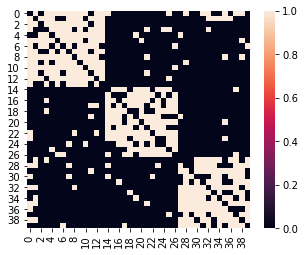

In [615]:
# util.plot_networkx_graph(G)
util.plot_networkx_adj(G)

## Save Graph.

In [624]:
nx.write_gpickle(G, project_dir+'Output/network/gaussianpart40_clique3_seed0_noise100_traitor2.pkl')

# Sigmoid Model.

In [ ]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')
args.embedding_dim = 10
args.learning_rate = 0.1
args.num_epochs = 8000
args.graph_file = project_dir+'Output/network/gaussianpart31_clique3_seed0.pkl'
print(args)
model = network.NetworkSigmoidModel(args)

In [1461]:
model.train(args, print_step=None)

itrs	loss
0	8.358e-01
800	1.537e-01
1600	1.467e-01
2400	1.409e-01
3200	1.367e-01
4000	1.321e-01
4800	1.296e-01
5600	1.261e-01
6400	1.247e-01
7200	1.230e-01
7999	1.225e-01


sum |adj_hat - adj_true|: 82.22
err ratio: 0.3079414767307839
err_max:0.5066206753253937 err_min:-0.5057737827301025


D:/Brain_Network/Code\network.py:249: RuntimeWarning: divide by zero encountered in true_divide
  seaborn.heatmap(err / adj_true, cmap='PiYG')


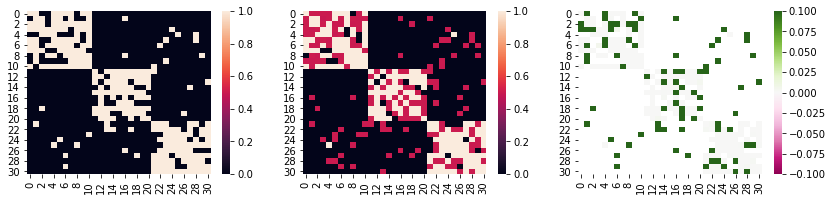

In [1462]:
model.plot_adj_hat()

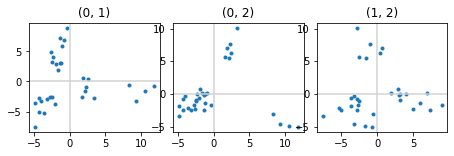

In [1463]:
model.plot_embedding_pca()
# model.plot_raw_embedding()

In [ ]:
model.decompose_adj()

# Sigmoid Query Model

In [62]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')
args.embedding_dim = 12
args.learning_rate = 0.1
args.num_epochs = 8000
args.graph_file = project_dir+'Output/network/798911424_condition5_area6_active.pkl'
print(args)
model = network.NetworkSigmoidQueryModel(args)

Namespace(embedding_dim=12, graph_file='D:/Brain_Network/Output/network/798911424_condition5_area6_active.pkl', learning_rate=0.1, num_epochs=8000)
num_nodes:178 num_edges:610


In [63]:
model.train(args, epsilon=1e-6, print_step=None)

itrs	loss
0	8.364e-01
800	7.318e-07


D:/Brain_Network/Code\network.py:301: RuntimeWarning: overflow encountered in exp
  adj_hat = 1/(1 + np.exp(-adj_hat))


sum |adj_hat - adj_true|: 0.023
err ratio: 1.6490569928093624e-05
err_max:6.854534149169922e-05 err_min:-5.2719697123393416e-05


D:/Brain_Network/Code\network.py:319: RuntimeWarning: divide by zero encountered in true_divide
  seaborn.heatmap(err / adj_true)
D:/Brain_Network/Code\network.py:319: RuntimeWarning: invalid value encountered in true_divide
  seaborn.heatmap(err / adj_true)


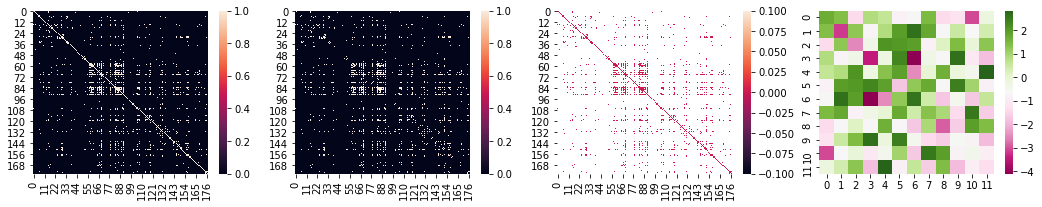

In [64]:
model.plot_query_adj_hat()

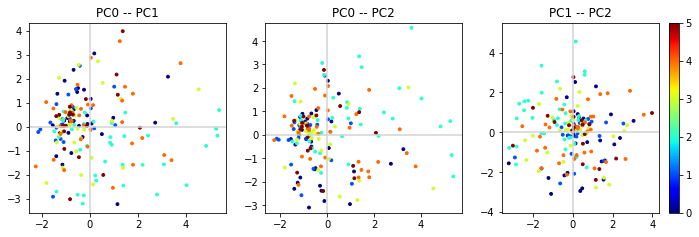

[ 10  16  18  20  24  30  52  63  80  96 102 129 136 167]


In [65]:
# model.plot_raw_embedding()
# model.plot_raw_query_embedding()
# model.plot_query_embedding_pca()
model.plot_embedding_pca([0,1,2])

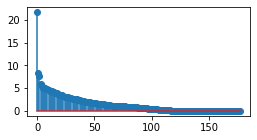

In [12]:
model.decompose_adj()

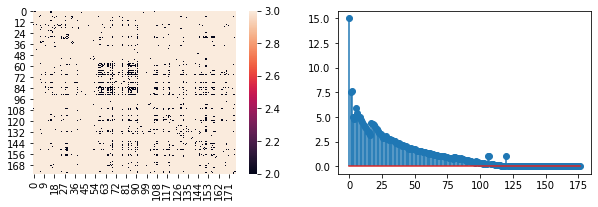

In [13]:
model.graph_laplacian()

# Multi-Graph Sigmoid Query Model

In [728]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')
args.embedding_dim = 9
args.embedding_penalty = 0.00005
args.learning_rate = 0.1
args.num_epochs = 60000
args.graph_file = [project_dir+'Output/network/gaussianpart40_clique3_seed0_traitor2.pkl', 
                   project_dir+'Output/network/gaussianpart40_clique3_seed0_noise50_traitor2.pkl',
                   project_dir+'Output/network/gaussianpart40_clique3_seed0_noise100_traitor2.pkl',]
print(args)
model = network.NetworkMultiGraphSigmoidQueryModel(args)

Namespace(embedding_dim=9, embedding_penalty=5e-05, graph_file=['D:/Brain_Network/Output/network/gaussianpart40_clique3_seed0_traitor2.pkl', 'D:/Brain_Network/Output/network/gaussianpart40_clique3_seed0_noise50_traitor2.pkl', 'D:/Brain_Network/Output/network/gaussianpart40_clique3_seed0_noise100_traitor2.pkl'], learning_rate=0.1, num_epochs=60000)
num_nodes:40
graph:0 num_edges:466
graph:1 num_edges:496
graph:2 num_edges:530


In [729]:
model.train(args, print_step=None)

itrs	loss
0	7.957e-01
6000	1.726e-01
12000	1.555e-01
18000	1.466e-01
24000	1.208e-01
30000	1.292e-01
36000	1.082e-01
42000	9.508e-02
48000	9.102e-02
54000	8.215e-02
59999	7.456e-02


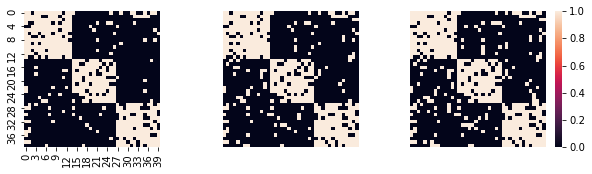

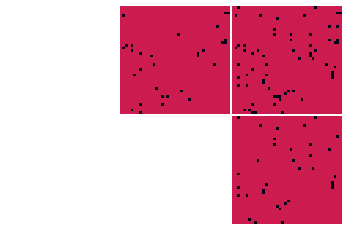

In [730]:
model.plot_multi_graph_adj()
model.plot_multi_graph_adj_contrast()

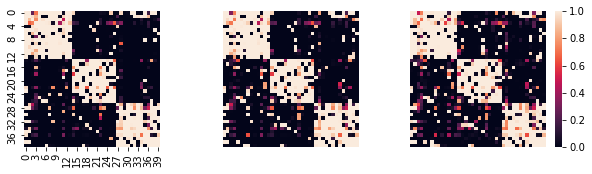

In [732]:
model.plot_multi_graph_adj_hat()

D:/Brain_Network/Code\network.py:388: RuntimeWarning: overflow encountered in exp
  adj_hat = 1/(1 + np.exp(-adj_hat))


sum |adj_hat - adj_true|: 46.56
err ratio: 0.029846185521814873
err_max:0.904538944363594 err_min:-0.9876376390457153


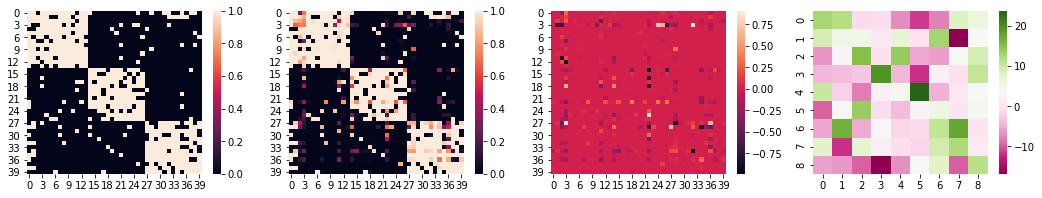

sum |adj_hat - adj_true|: 56.014
err ratio: 0.03590645844171917
err_max:0.9918299997225404 err_min:-0.9853264093399048


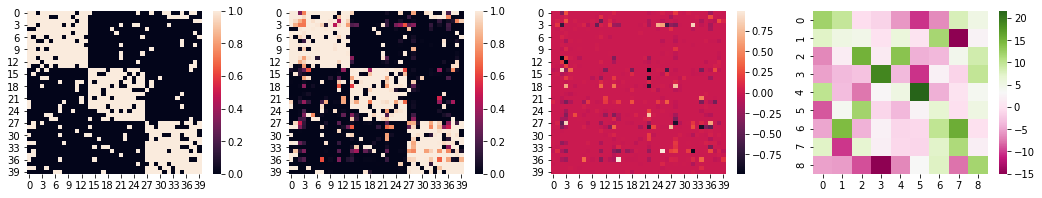

sum |adj_hat - adj_true|: 77.137
err ratio: 0.04944684175193535
err_max:0.9924856219440699 err_min:-0.9723560214042664


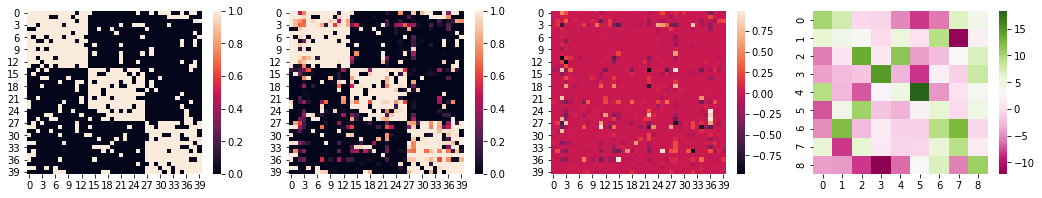

In [733]:
model.plot_multi_graph_query_adj_hat(0)
model.plot_multi_graph_query_adj_hat(1)
model.plot_multi_graph_query_adj_hat(2)

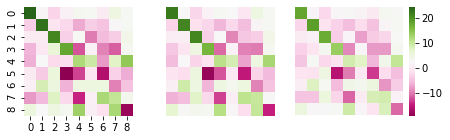

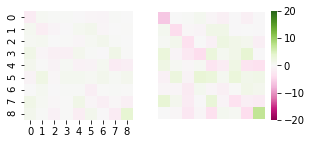

In [734]:
masks = model.plot_multi_graph_pca_query_spectrum(threshold=[-0 , 0 ])

In [738]:
model.compare_multi_graph_query_mat()

(0,1) F:9.23	cos:0.996	
U cos: [0.984 0.939 0.959 0.921 0.831 0.957 0.861 0.783 0.995]
V cos: [0.983 0.927 0.95  0.922 0.843 0.96  0.85  0.795 0.993]
D i: [37.636 31.261 27.953 25.914 23.957 23.082 20.676 18.889 12.005]
D j: [34.401 28.896 26.273 23.997 21.695 20.339 19.392 16.985 10.238]

(0,2) F:19.95	cos:0.991	
U cos: [0.921 0.723 0.841 0.886 0.727 0.83  0.736 0.621 0.99 ]
V cos: [0.906 0.685 0.816 0.882 0.736 0.823 0.74  0.654 0.996]
D i: [37.636 31.261 27.953 25.914 23.957 23.082 20.676 18.889 12.005]
D j: [29.213 24.34  22.728 19.776 17.652 16.591 16.166 13.626  8.785]

(1,2) F:12.34	cos:0.997	
U cos: [0.973 0.909 0.951 0.946 0.902 0.933 0.891 0.956 0.992]
V cos: [0.966 0.901 0.946 0.952 0.904 0.931 0.896 0.96  0.996]
D i: [34.401 28.896 26.273 23.997 21.695 20.339 19.392 16.985 10.238]
D j: [29.213 24.34  22.728 19.776 17.652 16.591 16.166 13.626  8.785]



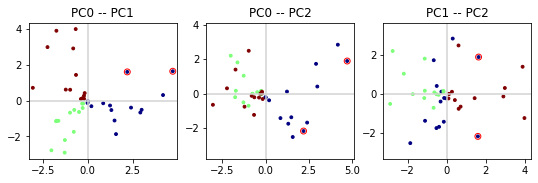

[ 2  3 11 14 22 25 27 28 32 34 36]


In [736]:
highlight_nodes = [0,1] # np.arange(27,40)
# model.plot_query_embedding_pca()
model.plot_embedding_pca([0,1,2], highlight_nodes)

0 1 3.2490696907043457
0 2 3.343391180038452
1 2 2.828313112258911


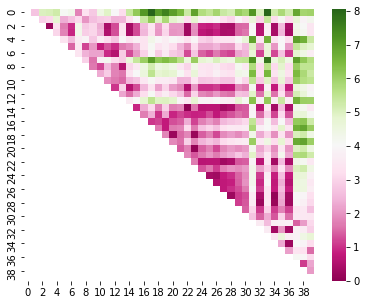

In [737]:
model.embedding_group_analysis(selected_nodes)

In [ ]:
# select_dim = [0,1,2,3,4,5,6,7,8,9,10,11,12]
select_dim_left = [0,1,2,3]
select_dim_right = [0,1,2,3]
model.plot_multi_graph_pca_query_adj_hat_dims(2, select_dim_left, select_dim_right)
# model.plot_multi_graph_pca_query_adj_hat_dims(1, select_dim)
# model.plot_multi_graph_pca_query_adj_hat_dims(2, select_dim)
# model.plot_multi_graph_pca_query_adj_hat_dims(3, select_dim)

In [266]:
# model.plot_multi_graph_pca_query_adj_hat_mask(2, masks[1])

In [395]:
# model.plot_multi_graph_query()
# model.multi_graph_query_svd()

In [397]:
# model.multi_graph_laplacian()

# Cat Query Model.

In [1129]:
parser = argparse.ArgumentParser()
parser.add_argument('--embedding_dim', default=10, type=int)
parser.add_argument('--learning_rate', default=0.2, type=float)
parser.add_argument('--num_epochs', default=20000, type=int)
parser.add_argument('--graph_file', type=str)

arg_str = ['--graph_file', project_dir+'Output/network/gaussianpart100_20_4_weight5.pkl', '--embedding_dim', '25']
args = parser.parse_args(arg_str)
print(args)

model = network.NetworkCategoricalQueryModel(args)

Namespace(embedding_dim=25, graph_file='D:/Brain_Network/Output/network/gaussianpart100_20_4_weight5.pkl', learning_rate=0.2, num_epochs=20000)
num_nodes:100 num_edges:2277


In [1130]:
model.train(args)

itrs	loss
0	1.608e+00
2000	9.779e-01
4000	8.380e-01
6000	4.027e-01
8000	3.866e-01
10000	1.474e-01
12000	1.105e-01
14000	4.132e-02
16000	1.181e-02
18000	5.830e-07
19999	4.168e-07


sum |adj_hat - adj_true|: 0.005446784574812507
err ratio: 5.446784574812507e-07


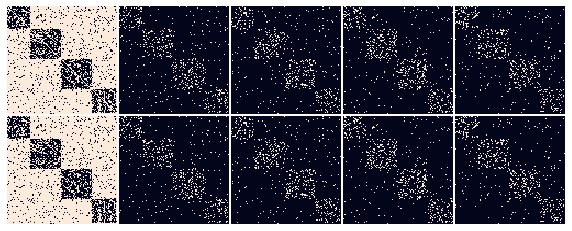

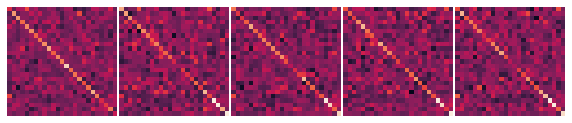

In [1131]:
model.plot_cat_query_adj_hat()

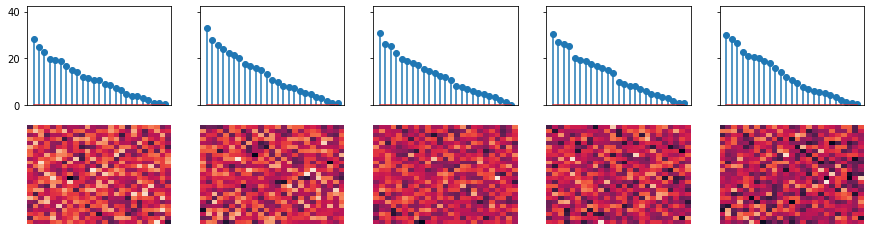

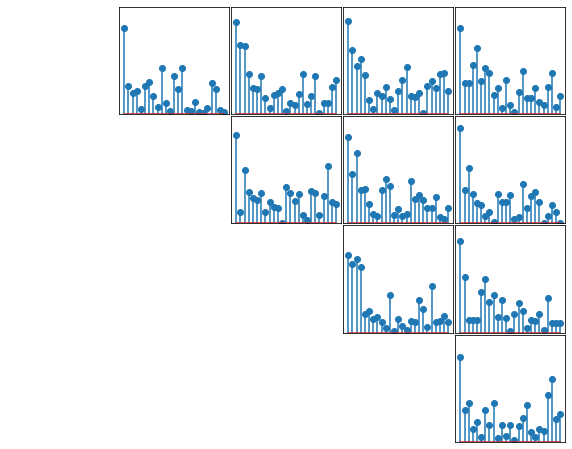

In [1136]:
model.plot_cat_query()
model.compare_cat_query_mat()

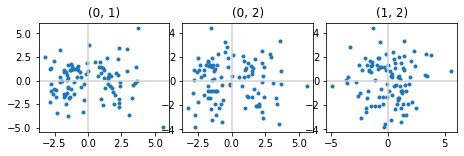

In [1137]:
# model.plot_query_embedding_pca()
model.plot_embedding_pca(3)

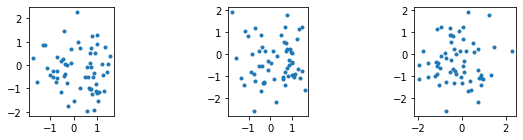

In [755]:
model.plot_raw_embedding()
# model.plot_raw_query_embedding()

# Softmax Model.

In [538]:
parser = argparse.ArgumentParser()
parser.add_argument('--embedding_dim', default=10, type=int)
parser.add_argument('--learning_rate', default=0.2, type=float)
parser.add_argument('--num_epochs', default=8000, type=int)
parser.add_argument('--graph_file', type=str)

arg_str = ['--graph_file', project_dir+'Output/network/4x20_noisy250_weight10_clique.pkl', '--embedding_dim', '25']
args = parser.parse_args(arg_str)
print(args)

model = network.NetworkSoftmaxModel(args)

Namespace(embedding_dim=25, graph_file='D:/Brain_Network/Output/network/4x20_noisy250_weight10_clique.pkl', learning_rate=0.2, num_epochs=8000, proximity='first-order')
num_nodes:80 num_edges:939


In [539]:
model.train(args)

itrs	loss
0	5.640e+00
800	3.231e+00
1600	3.198e+00
2400	3.175e+00
3200	3.155e+00
4000	3.103e+00
4800	3.075e+00
5600	3.053e+00
6400	3.027e+00
7200	3.013e+00
7999	3.006e+00


sum |adj_hat - adj_true|: 1.567e-01
err ratio: 0.0019587191722405407
err_max:0.00030588628995476333 err_min:-0.00031305436904613404


D:/Brain_Network/Code\network.py:189: RuntimeWarning: divide by zero encountered in true_divide
  seaborn.heatmap(err / adj_true)
D:/Brain_Network/Code\network.py:189: RuntimeWarning: invalid value encountered in true_divide
  seaborn.heatmap(err / adj_true)


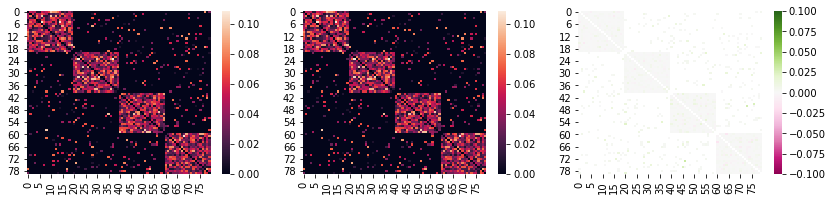

In [546]:
model.plot_prob_adj_hat()

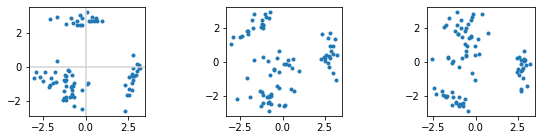

In [279]:
model.plot_embedding_pca()
# model.plot_raw_embedding()

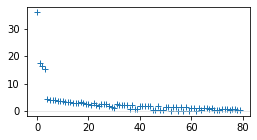

In [281]:
model.decompose_adj()

# Softmax Prob Query Model.

In [525]:
parser = argparse.ArgumentParser()
parser.add_argument('--embedding_dim', default=10, type=int)
parser.add_argument('--learning_rate', default=0.2, type=float)
parser.add_argument('--num_epochs', default=8000, type=int)
parser.add_argument('--graph_file', type=str)

arg_str = ['--graph_file', project_dir+'Output/network/4x20_noisy250_weight10_clique.pkl', '--embedding_dim', '18']
args = parser.parse_args(arg_str)
print(args)

model = network.NetworkSoftmaxQueryModel(args)

Namespace(embedding_dim=18, graph_file='D:/Brain_Network/Output/network/4x20_noisy250_weight10_clique.pkl', learning_rate=0.2, num_epochs=8000, proximity='first-order')
num_nodes:80 num_edges:939


In [526]:
model.train(args)

itrs	loss
0	5.116e+00
800	3.549e+00
1600	3.527e+00
2400	3.396e+00
3200	3.302e+00
4000	3.253e+00
4800	3.196e+00
5600	3.156e+00
6400	3.098e+00
7200	3.042e+00
7999	3.008e+00


sum |adj_hat - adj_true|: 1.618e+00
err ratio: 0.020226254760024355
err_max:0.006299921806822428 err_min:-0.006009532653904977


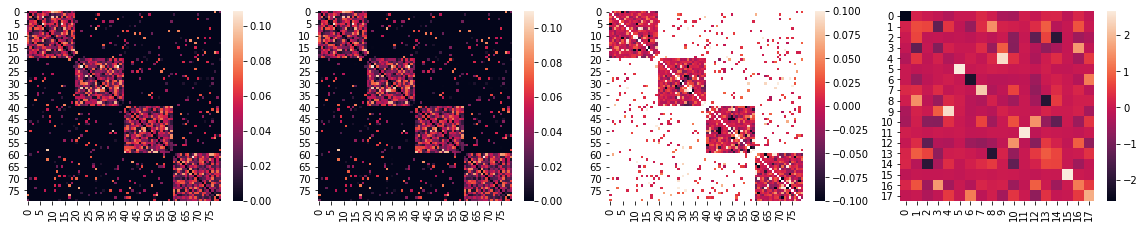

In [527]:
model.plot_prob_query_adj_hat()

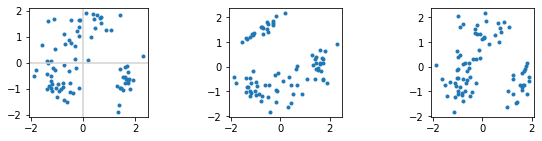

In [519]:
# model.plot_query_embedding_pca()
model.plot_embedding_pca()

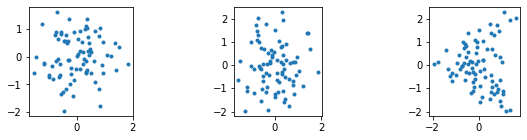

In [520]:
# model.plot_raw_embedding()
model.plot_raw_query_embedding()

# Simple unit tests.

In [1116]:
import tensorflow.compat.v1 as tf
np.random.seed(1)
m = np.random.randint(0,10, [5,5])
rows, cols = np.where(~np.eye(5,dtype=bool))
rows = rows.reshape(5,4)
cols = cols.reshape(5,4)

x = tf.placeholder('float32', (None, None))
idx1 = tf.placeholder('int32', (None, None))
idx2 = tf.placeholder('int32', (None, None))
idx = tf.stack((idx1, idx2), -1)
result = tf.gather_nd(x, idx)

with tf.Session() as sess:
    idx_out = sess.run(idx, feed_dict={x: m, idx1: rows, idx2: cols})
    r = sess.run(result, feed_dict={x: m, idx1: rows, idx2: cols})

print(m)
# print(idx_out)
# print(rows)
# print(cols)
# print(idx_out.shape)
print(r)

[[5 8 9 5 0]
 [0 1 7 6 9]
 [2 4 5 2 4]
 [2 4 7 7 9]
 [1 7 0 6 9]]
[[8. 9. 5. 0.]
 [0. 7. 6. 9.]
 [2. 4. 2. 4.]
 [2. 4. 7. 9.]
 [1. 7. 0. 6.]]


In [582]:
x = np.ones([3,1,1])
y = np.expand_dims(np.eye(4), axis=0)
z = x *  y
print(x.shape)
print(y.shape)
print(z.shape)
print(z)

(3, 1, 1)
(1, 4, 4)
(3, 4, 4)
[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]


### Test data loader.

In [ ]:
H = nx.read_gpickle(project_dir+'Output/network/3x5_weight3_clique.pkl')
pos=nx.circular_layout(H)
nx.draw(H, pos=pos)

In [559]:
data_loader = network.GraphLoader(graph_file=project_dir+'Output/network/3x5_weight3_clique.pkl')

num_nodes:15 num_edges:30


In [567]:
u_i, u_j, label = data_loader.fetch_categorical()
# print(u_i)
print(len(label))
print(label)
# G[0][2]

210
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0

In [ ]:
label = data_loader.fetch_prob_mat()
print(np.round(label, 4))
print(label.sum(axis=0))
print(label.sum(axis=1).T)

In [633]:
label = data_loader.fetch_cat_tensor()
# print(label)

In [1355]:
args.graph_file = [project_dir+'Output/network/gaussianpart31_clique3_seed0.pkl',
                   project_dir+'Output/network/gaussianpart31_clique3_seed1.pkl',
                   project_dir+'Output/network/gaussianpart31_clique3_seed2.pkl',
                   project_dir+'Output/network/gaussianpart31_clique3_seed3.pkl']
data_loader = network.MultiGraphLoader(graph_file_list=args.graph_file)
u_i, u_j, label = data_loader.fetch_binary()
print(len(u_i))
print(label.shape)

num_nodes:31
graph:0 num_edges:236
graph:1 num_edges:233
graph:2 num_edges:235
graph:3 num_edges:233
930
(4, 930)


In [307]:
import tensorflow.compat.v1 as tf
x = np.ones([4,3])
v = tf.placeholder('float32', (None, None))
loss = tf.nn.l2_loss(v)

with tf.Session() as sess:
    out = sess.run(loss, feed_dict={v: x})

print(x)
print(out)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
6.0
